In [1]:
import os
import json
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from datetime import datetime, timedelta

from google.cloud import bigquery
from google.oauth2 import service_account

pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_columns', None)

#pd.set_option('display.max_rows',None)     # 모든 행 보기
#pd.reset_option('display.max_rows')  

In [2]:
df = pd.read_csv('ga4_data.csv')

/var/folders/mk/p5y6cznx60788rys6_dnljxm0000gn/T/ipykernel_16332/4055328101.py:1: DtypeWarning: Columns (1,29) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ga4_data.csv')


In [3]:
df['visitStartTime'] = pd.to_datetime(df['visitStartTime'])
df['totals_totalTransactionRevenue'] = df['totals_totalTransactionRevenue'].fillna(0)
df['hits_transaction_transactionRevenue'] = df['hits_transaction_transactionRevenue'].fillna(0)
#df.loc[(df.trafficSource_medium == 'organic') & (df.trafficSource_keyword.isnull()), 'trafficSource_keyword'] = '(not provided)'
#df.loc[(df.trafficSource_medium.isin(["(none)", 'affiliate'])) & (df.trafficSource_keyword.isnull()), 'trafficSource_keyword'] = '(not set)'

df.visitStartTime = (df.visitStartTime - timedelta(hours=7))
df = df.assign(month = df.visitStartTime.dt.strftime('%Y-%m'))
df = df.assign(date = df.visitStartTime.dt.strftime('%m-%d'))
df = df.assign(day_name = df.visitStartTime.dt.weekday)

df['fullVisitorId'] = df['fullVisitorId'].astype(str)

def pad_with_zeros(string):
    """
    문자열의 길이가 19이 될 때까지 앞에 0을 추가하는 함수
    """
    # 문자열의 길이를 세기
    length = len(string)
    
    # 문자열의 길이가 20이 될 때까지 앞에 0을 추가
    while length < 19:
        string = '0' + string
        length += 1
    
    return string

df['fullVisitorId'] = df['fullVisitorId'].apply(pad_with_zeros)

# 단계별 퍼널

In [4]:
# 기간 내 고유 방문 : 250143
# 기간 내 액티브(장바구니) : 25117
# 리텐션
# 고유 구매건수 : 9421
# 추천

In [4]:
import plotly.express as px

# 전체 고유방문객수
acquisition = df.fullVisitorId.nunique()

# 장바구니 이용 고유 고객수
add_to_cart = df[df.hits_eCommerceAction_action_type ==3]
active = add_to_cart.fullVisitorId.nunique()

#주문완료 고유 고객수
check_confirm = df[df.hits_transaction_transactionRevenue !=0]
revenue = check_confirm.fullVisitorId.nunique()

data = dict(
    number = [acquisition, active, revenue],
    stage = ['Acqusition', 'Active', 'Purchase']
)
fig = px.funnel(data, x='number', y='stage')
fig.show()

In [5]:
# 장바구니 전환율율(고객수->장바구니)
active_conver = round(active / acquisition * 100, 2)
# 구매 전환율율(장바구니 -> 구매)
rev_conver = round(revenue / active * 100, 2)

print(active_conver, rev_conver)

10.04 37.51


# 분석 기간 내 유저 당 방문 수

In [5]:
visit_cnt = df.groupby('fullVisitorId').visitNumber.nunique().reset_index(name = 'cnt')
visit_cnt

,fullVisitorId,cnt
0,0000005103959234087,1
1,0000027376579751715,1
2,0000035794135966385,1
3,0000040862739425590,2
4,0000045417921646651,1
...,...,...
250138,9999801229043043045,1
250139,9999803502828528029,1
250140,9999906724458612544,1
250141,9999955365228667450,1


# MAU

In [6]:
df_visit = df.groupby('month')['fullVisitorId'].nunique().reset_index(name='visit_cnt')
df_visit


,month,visit_cnt
0,2016-08,22675
1,2016-09,20778
2,2016-10,23896
3,2016-11,22932
4,2016-12,27362
5,2017-01,21782
6,2017-02,20629
7,2017-03,22018
8,2017-04,21050
9,2017-05,22794


In [7]:
df_visit.to_csv('mau.csv', index=False)

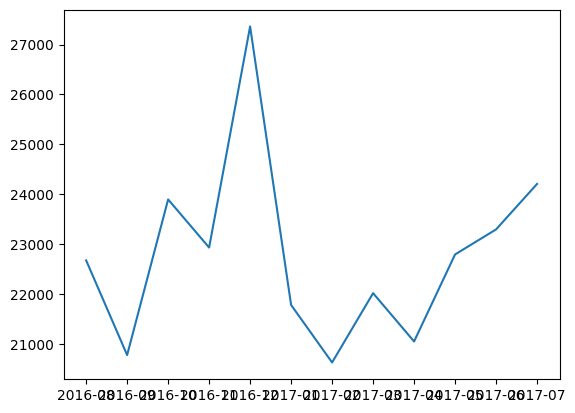

In [8]:
plt.plot(df_visit.month, df_visit.visit_cnt)